In [1]:
import astropy as ap
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad as quad
from tqdm import tqdm
import emcee

In [2]:
from astropy.table import Table

# Load the fits file
data = Table.read('StellarMassesv19.fits', format='fits')

#print (data.colnames)
filter_data = data[(data['logmstar'] > 9) & (data['Z'] > 0.035) & (data['Z'] < 0.065) & (data['fluxscale'] > 0.3) & (data['fluxscale'] < 3)]

fluxscale = filter_data['fluxscale']
z = filter_data['Z']
logM = filter_data['logmstar']+np.log10(fluxscale)
dlogM = filter_data['dellogmstar']

\begin{equation}
    N_{exp} = \oint dV \oint_{M_l}^{M_h} d\log M
\end{equation}

\begin{equation}
    L = \frac{1}{\sqrt{2\pi N_{exp}}} exp \left[\frac{-1}{2} \left( \frac{N_{obs} - N_{exp}}{\sqrt{Nexp}}\right)^2\right]
\end{equation}

In [10]:
#define all the functions

def schechter_func(ln_mass, phi_star, ln_m_star, alpha):
    x = ln_mass - ln_m_star
    #print(alpha,ln_m_star)
    sch = np.log(10)*phi_star*((10**x)**(alpha+1))*np.exp(-10**x)
    sch = np.where(np.isfinite(sch), sch, 0)
    return sch
    
def schechter_new(ln_mass, phi_star, ln_m_star1, alpha1, ln_m_star2, alpha2, f1):
    sch1 = f1*schechter_func(ln_mass, phi_star, ln_m_star1, alpha1)
    sch2 = (1-f1)*schechter_func(ln_mass,phi_star, ln_m_star2, alpha2)
    return (sch1+sch2)

def schechter_int(ln_mass, phi_star,ln_m_star, alpha):
    # Efficient integral computation
    func = lambda x: np.log(10) * phi_star * (10**((x - ln_m_star) * (alpha + 1))) * np.exp(-10**(x - ln_m_star))
    norm, _ = quad(func, a=np.min(ln_mass), b=np.max(ln_mass))
    return norm

In [5]:
def comoving_volume(z_initial, z_final, H0=70, Omega_M=0.3, Omega_Lambda=0.7):
    c = 3e5 #light speed in km/s as H0 is 70km/s/MPc
    # For a flat universe, Omega_k = 0
    Omega_k = 1 - Omega_M - Omega_Lambda  
    # Hubble distance in Mpc
    DH = c / H0  

    # Angular size distance
    def E(z, Omega_M=Omega_M, Omega_Lambda=Omega_Lambda, Omega_k=Omega_k):
        return np.sqrt(Omega_M * (1 + z)**3 + Omega_k * (1 + z)**2 + Omega_Lambda)

    # Integral for comoving distance DC
    def comoving_distance(z):
        return quad(lambda z: 1/E(z), 0, z)[0] * DH

    # Calculate DC for initial and final redshifts
    DC_initial = comoving_distance(z_initial)
    DC_final = comoving_distance(z_final)

    # Volume of the light cone V_C using the formula for Omega_k = 0 (flat universe)
    VC_initial = (4 * np.pi / 3) * DC_initial**3
    VC_final = (4 * np.pi / 3) * DC_final**3

    # The volume covered between z_initial and z_final is the difference
    V_360 = VC_final - VC_initial
    
    #full sky has 41253 sq degrees and GAMA has 250sq degrees
    V_gama = 143/41253 * V_360
    
    return V_gama

# Initial and final redshifts
z_initial = 1e-6
z_final = 0.065

# Calculate and print the volume of the light cone
volume = comoving_volume(z_initial, z_final)
print(f"The volume of the light cone between z={z_initial} and z={z_final} is approximately {volume:.2f} cubic Mpc.")

The volume of the light cone between z=1e-06 and z=0.065 is approximately 300145.55 cubic Mpc.


In [6]:
from astropy.cosmology import Planck15
def co_vol(z_initial, z_final, Omega = 0.0873):
    V23  = Planck15.comoving_volume(z_final) - Planck15.comoving_volume(z_initial)
    V    = Omega/(4*np.pi) * V23
    return V.value

In [7]:
def pslike(ln_mass,phi_star, ln_m_star, alpha):
    #expected Number Counts
    def Nexp(ln_mass, phi_star, ln_m_star, alpha, z_initial=1e-6, z_final=0.065):
        V=comoving_volume(z_initial,z_final)
        phi_int =  schechter_int(ln_mass, phi_star, ln_m_star, alpha)
        Nexp = V * phi_int
        return Nexp
    
    #log Likelihood
    Nobs = len(z)
    Nexp = Nexp(ln_mass,phi_star, ln_m_star, alpha)
    logL =(-1./2)*((Nobs-Nexp)**2)/Nexp -(1/(2*np.log(2*np.pi*Nexp)))
    
    #print(logL, Nobs, Nexp)
    return logL

In [8]:
def lnlike(parvals, data, uncerts, return_model=False):
    alpha, ln_m_star, phi_star = parvals
    ln_mass= data 
    
    if ln_m_star < 8 and phi_star < 0:
        return -np.inf
    
    lnprior = -0.5*( (-2 - alpha)/1.5 )**2.
    # gaussian prior on alpha, centred at -1, with stderr 1.5
    
    # Vectorized calculation of the Schechter function
    sch = schechter_func(ln_mass, phi_star, ln_m_star, alpha)
    
    # Efficient integral computation
    norm = schechter_int(ln_mass, phi_star, ln_m_star, alpha)
    
    const = 1e-10  # To avoid log(0)
    
    #Vectorized log sum and normalization
    #L = np.nansum(np.log(sch + const)) - len(ln_mass) * np.log(norm + const)

    like = np.clip( sch / norm, 1e-12, np.inf )
    L = np.nansum( np.log( like ) )
    
    if return_model :
        return np.clip( sch / norm, 1e-12, np.inf )

    like = np.clip( sch / norm, 1e-12, np.inf )
    L = np.nansum( np.log( like ) )
    
    #print( alpha, ln_m_star, L)
    return L + lnprior #+ pslike(ln_mass, phi_star, ln_m_star, alpha)

In [9]:
def plot_obs_mf(logM, color):
    vol = co_vol(0.035,0.065)
    logmstep=0.1
    bins = np.arange(min(logM), max(logM)+1e-10, logmstep)
    counts, bins = np.histogram(logM, bins)
    mf = counts / logmstep / vol
    plt.plot(bins[:-1],mf, color=color, label='observed', drawstyle='steps-pre')
    
def plot_model_mf(parvals, data, uncert, color):
    
    alpha, ln_m_star, phi_star = parvals
    ln_mass= data 
    
    def ind_like(parvals, data, uncerts):

        # Vectorized calculation of the Schechter function
        sch = schechter_func(ln_mass, phi_star, ln_m_star, alpha)

        # Efficient integral computation
        #norm = schechter_int(ln_mass, phi_star, ln_m_star, alpha)

        like = np.clip( sch, 1e-12, np.inf )
        return like
    
    plt.scatter(data, ind_like(parvals,data,uncert), s=1, color=color, label='model')

100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1618.37it/s]


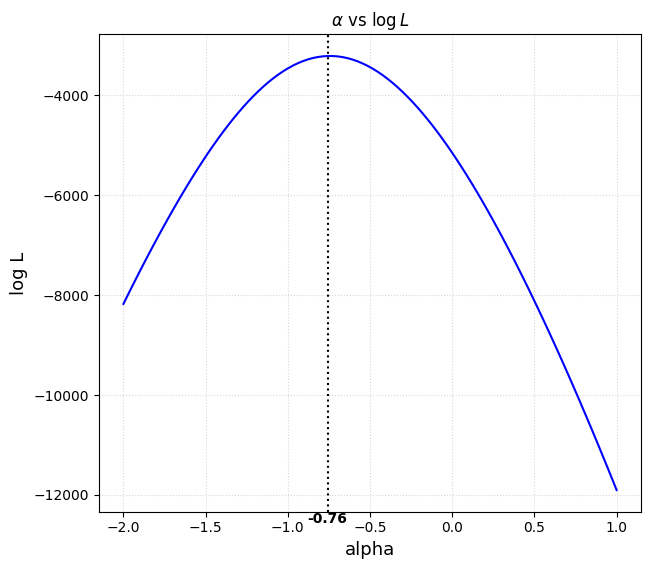

In [20]:
alpha = np.linspace(-2,1,100)
L_values = np.zeros(len(alpha))
L_values2 = np.zeros(len(alpha))


from tqdm import tqdm
for i in tqdm(range(len(alpha))):
    phi_star, logM_star = 3.96e-3, 10.66
    L_values[i] = lnlike((alpha[i],logM_star, phi_star), logM, dlogM)
    #L_values2[i] = lnlike2((alpha[i],logM_star, phi_star), logM, dlogM)

    
plt.figure(figsize=(7,6.2))

minima = alpha[np.argmax(L_values)]

plt.plot(alpha,L_values, color= 'blue')

plt.axvline(x = minima, color = 'black',linestyle=':', label = 'axvline - full height')

plt.text(minima-0.005, plt.gca().get_ylim()[0]-7, str(round(minima,2)), ha='center', va='top', fontweight=1000)

plt.title(r'$\alpha$ vs $\log L$')

plt.grid(alpha=0.5, linestyle=':')

plt.xlabel('alpha', fontsize=13)
plt.ylabel('log L', fontsize=13)

plt.show()

In [21]:
alpha = -1.47, -0.35
phi_star, ln_m_star = 0.79e-3, 10.66 , 3.96e-3
parvals = (alpha, ln_m_star, phi_star)

plt.figure(figsize=(8,7))

plt.yscale('log')
plot_model_mf(parvals,logM, dlogM, 'red')
plot_obs_mf(logM,'blue')

plt.legend()
#plt.ylim(1e-11, 1e-5)

ValueError: too many values to unpack (expected 2)

# 2 Schechter Fit

In [10]:
def schechter_new(parvals, data): #data=logM
    [alpha1, alpha2], log_m_star, [phi_star1,phi_star2]= parvals
    log_mass= data
    x = 10**(data-log_m_star)
    
    sch1 = phi_star1*(x**(alpha1+1))
    sch2 = phi_star2*(x**(alpha2+1))
    return (sch1+sch2)*np.exp(-x)*np.log(10)

def plot_obs_mf(logM, color):
    #vol = co_vol(0.035,0.065)
    vol = comoving_volume(0.035,0.065)
    logmstep=0.1
    bins = np.arange(min(logM), max(logM)+1e-10, logmstep)
    counts, bins = np.histogram(logM, bins)
    mf = counts / logmstep / vol
    #plt.plot(bins[:-1],mf, color=color, label='observed', drawstyle='steps-post')
    plt.scatter(bins[:-1]+0.05,mf, color=color, s=4, label='observed')

    
def plot_2_model_mf(parvals, data, uncert, color):
    
    [alpha1, alpha2], log_m_star, [phi_star1,phi_star2]= parvals
    log_mass= data 
    
    def new_int(alpha, phi_star):
        func = lambda x: np.exp(-x)*(phi_star*(x**alpha))
        norm, _ =  quad(func, a=np.min(log_mass), b=np.max(log_mass))
        return norm
    
    def ind_like(parvals, data, uncerts):

        # Vectorized calculation of the Schechter function
        sch = schechter_new(parvals, data)

        #new integral computation 
        #norm = new_int(alpha1, phi_star1) + new_int(alpha2, phi_star2)
        like = np.clip( sch, 1e-12, np.inf)
        
        return like
    
    plt.scatter(data, ind_like(parvals,data,uncert), s=1, color=color, label='model')

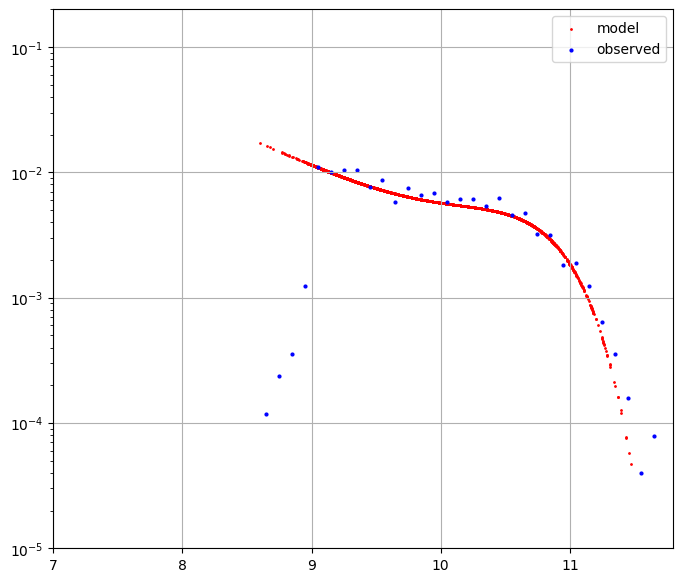

In [11]:
[alpha1, alpha2] = [-1.47, -0.35]
[phi_star1, phi_star2] = [0.79e-3, 3.96e-3]
m_star = 10.66

parvals = [alpha1, alpha2], m_star, [phi_star1, phi_star2]


plt.figure(figsize=(8,7))

plt.yscale('log')
plot_2_model_mf(parvals,logM, dlogM, 'red')
plot_obs_mf(logM,'blue')

plt.legend()
plt.ylim(1e-5, 2e-1)
plt.xlim(7,11.8)

plt.grid()

# MCMC

In [38]:
from scipy.special import gammainc

def lnlike_2model(parvals, data, uncerts):
    [alpha1, alpha2], log_m_star, [phi_star1,phi_star2]= parvals
    log_mass= data 
    
    if log_m_star < 8 and phi_star1 < 0 and phi_star2 <0:
        return -np.inf
    
    def new_sch(parvals, data): #data=logM
        [alpha1, alpha2], log_m_star, [phi_star1,phi_star2]= parvals
        log_mass= data
        x = 10**(data-log_m_star)
        sch1 = phi_star1*(x**(alpha1+1))
        sch2 = phi_star2*(x**(alpha2+1))
        return (sch1+sch2)*np.exp(-x)*np.log(10)
    
    def new_int(parvals, data):
        [alpha1, alpha2], log_m_star, [phi_star1,phi_star2]= parvals
        log_mass= data 
        [a,b] = [min(log_mass),max(log_mass)]
        norm = np.log(10)*(phi_star1*gammainc(alpha1+2,a)-phi_star1*gammainc(alpha1+2,b))-np.log(10)*(phi_star2*gammainc(alpha2+2,a)-phi_star2*gammainc(alpha2+2,b))
        return norm
    
    def pslike(parvals, data):
        #expected Number Counts
        def Nexp(parvals, data, z_initial=0.035, z_final=0.065):
            V=comoving_volume(z_initial,z_final)
            phi_int =  new_int(parvals, data)
            Nexp = V * phi_int
            return Nexp

        #log Likelihood
        Nobs = len(z)
        Nexp = Nexp(parvals, data)
        logL =(-1./2)*((Nobs-Nexp)**2)/Nexp -(1/(2*np.log(2*np.pi*Nexp)))

        #print(logL, Nobs, Nexp)
        return logL
    
    
    lnprior_alpha1 = -0.5 * ((-1 - alpha1) / 1.5) ** 2
    lnprior_alpha2 = -0.5 * ((-1 - alpha2) / 1.5) ** 2
    # gaussian prior on alpha, centred at -1, with stderr 1.5
    lnprior = lnprior_alpha1 + lnprior_alpha2
    
    
    # Vectorized calculation of the Schechter function
    sch = schechter_new(parvals, data)
    
    # Efficient integral computation
    norm = new_int(parvals, data)

    like = np.clip( sch / norm, 1e-12, np.inf )
    L = np.nansum( np.log( like ) )
    
    #print( alpha, ln_m_star, L)
    return L + lnprior #+ pslike(ln_mass, phi_star, ln_m_star, alpha)

In [45]:
def new_int(parvals, data):
    [alpha1, alpha2], log_m_star, [phi_star1,phi_star2]= parvals
    log_mass= data 
    [a,b] = [min(log_mass),max(log_mass)]
    norm = np.log(10)*(phi_star1*gammainc(alpha1+2,a)-phi_star1*gammainc(alpha1+2,b))-np.log(10)*(phi_star2*gammainc(alpha2+2,a)-phi_star2*gammainc(alpha2+2,b))
    return norm

def pslike(parvals, data):
    #expected Number Counts
    def Nexp(parvals, data, z_initial=0.035, z_final=0.065):
        V=comoving_volume(z_initial,z_final)
        phi_int =  new_int(parvals, data)
        #print(phi_int)
        Nexp = V * phi_int
        return Nexp

    #log Likelihood
    Nobs = len(z)
    Nexp = Nexp(parvals, data)
    logL =(-1./2)*((Nobs-Nexp)**2)/Nexp -(1/(2*np.log(2*np.pi*Nexp)))

    print(Nobs, Nexp)
    return logL

In [46]:
[alpha1, alpha2] = [-1.47, -0.35]
[phi_star1, phi_star2] = [0.79e-3, 3.96e-3]
m_star = 10.66

parvals = [alpha1, alpha2], m_star, [phi_star1, phi_star2]

pslike(parvals, logM)

3496 1.9359263869381995


-3153137.590285388

In [36]:
a=np.min(logM)
b=np.max(logM)
phi_star1*gammainc(alpha1+2,a)-phi_star1*gammainc(alpha1+2,b)

-2.9139193973969774e-08